In [56]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
imageSize= 256
batchSize= 32
channels= 3
input_shape= 

In [3]:
data= tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage", 
    shuffle= True, 
    image_size= (imageSize, imageSize), 
    batch_size= batchSize
)

Found 2152 files belonging to 3 classes.


In [4]:
classNames= data.class_names
classNames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(data)

68

In [7]:
for image_batch, label_batch in data.take(1):
    print(image_batch[0].shape)
    print(image_batch.shape)
    print(label_batch)
    print(label_batch.numpy())

(256, 256, 3)
(32, 256, 256, 3)
tf.Tensor([0 2 1 0 1 1 1 1 1 1 1 0 1 1 1 1 2 0 1 0 2 0 1 0 0 1 0 2 0 1 1 1], shape=(32,), dtype=int32)
[0 2 1 0 1 1 1 1 1 1 1 0 1 1 1 1 2 0 1 0 2 0 1 0 0 1 0 2 0 1 1 1]


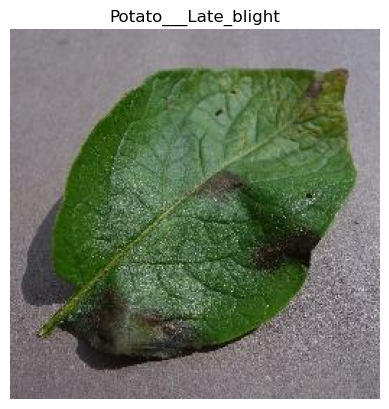

In [8]:
for image_batch, label_batch in data.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(classNames[label_batch[0]])
    plt.axis("off")

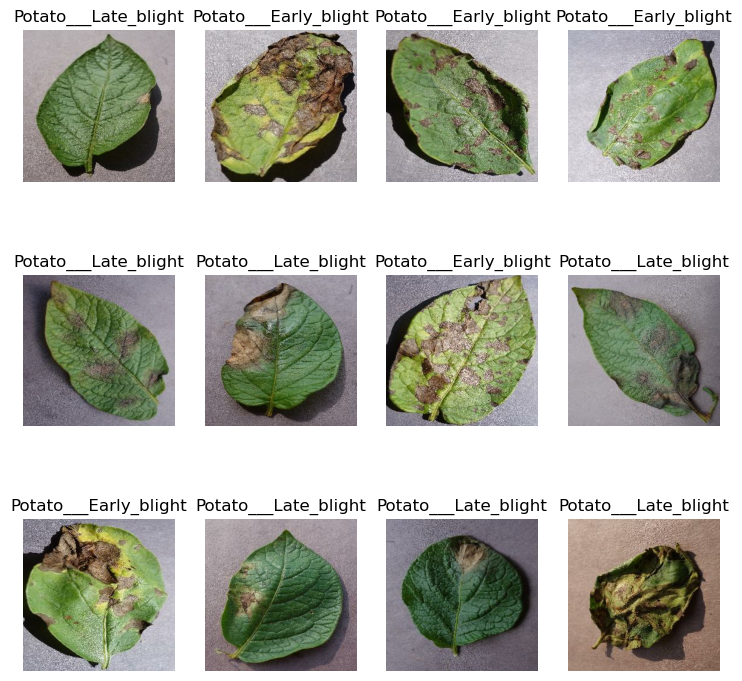

In [9]:
plt.figure(figsize=(9,9))
for image_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classNames[label_batch[i]])
        plt.axis("off")

# Splitting the dataset into train, test and validation sets

In [20]:
def train_val_test_split(ds, train=0.8, val=0.1, test=0.1, shuffle=True, shuffle_size=10000):
    data_size= len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
        
    train_size= int(data_size*train)
    val_size= int(data_size*val)
    
    train_ds= ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds= train_val_test_split(data)

In [28]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [33]:
len(test_ds)

8

In [27]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_scale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [32]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

In [37]:
inputShape= (batchSize, imageSize, imageSize, channels)
n_class= len(data.class_names)

model= models.Sequential([
    resize_scale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=inputShape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax'),
])

model.build(input_shape=inputShape)

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [41]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ["accuracy"]
)

history= model.fit(train_ds,
                  epochs=50,
                  batch_size= batchSize,
                  verbose= 1,
                  validation_data= val_ds)


Epoch 1/50

54/54 [==============================] - 223s 3s/step - loss: 0.9162 - accuracy: 0.4699 - val_loss: 0.9365 - val_accuracy: 0.4844
Epoch 2/50
54/54 [==============================] - 183s 3s/step - loss: 0.6837 - accuracy: 0.6991 - val_loss: 0.4573 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 90s 2s/step - loss: 0.4343 - accuracy: 0.8032 - val_loss: 0.4311 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 75s 1s/step - loss: 0.3143 - accuracy: 0.8663 - val_loss: 0.2986 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 78s 1s/step - loss: 0.2924 - accuracy: 0.8912 - val_loss: 0.3128 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 73s 1s/step - loss: 0.2437 - accuracy: 0.9028 - val_loss: 0.2716 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 71s 1s/step - loss: 0.2122 - accuracy: 0.9207 - val_loss: 0.1784 - val_accuracy: 0.9323
Epoch 8/50
54/54

In [42]:
#evaluating the model
evaluation= model.evaluate(test_ds)
evaluation

8/8 [==============================] - 5s 301ms/step - loss: 0.0499 - accuracy: 0.9922


[0.049879126250743866, 0.9921875]

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
accuracy= history.history["accuracy"]
validation_accuracy= history.history["val_accuracy"]

loss= history.history["loss"]
validation_loss= history.history["val_loss"]

In [48]:
accuracy

[0.46990740299224854,
 0.6990740895271301,
 0.8032407164573669,
 0.8663194179534912,
 0.8912037014961243,
 0.9027777910232544,
 0.9207175970077515,
 0.9479166865348816,
 0.9456018805503845,
 0.9560185074806213,
 0.9560185074806213,
 0.9473379850387573,
 0.9444444179534912,
 0.9652777910232544,
 0.9780092835426331,
 0.9681712985038757,
 0.9762731194496155,
 0.9809027910232544,
 0.9797453880310059,
 0.96875,
 0.984375,
 0.984375,
 0.9837962985038757,
 0.9832175970077515,
 0.9704861044883728,
 0.9745370149612427,
 0.9571759104728699,
 0.9826388955116272,
 0.9855324029922485,
 0.9907407164573669,
 0.9901620149612427,
 0.9849537014961243,
 0.9861111044883728,
 0.9901620149612427,
 0.9722222089767456,
 0.9878472089767456,
 0.9918981194496155,
 0.9751157164573669,
 0.9895833134651184,
 0.984375,
 0.9913194179534912,
 0.984375,
 0.9947916865348816,
 0.9861111044883728,
 0.9965277910232544,
 0.9837962985038757,
 0.9884259104728699,
 0.9895833134651184,
 0.9913194179534912,
 0.9942129850387573]

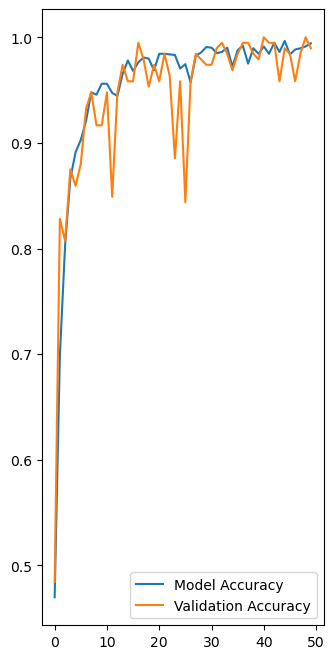

In [52]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), accuracy, label= "Model Accuracy")
plt.plot(range(50), validation_accuracy, label= "Validation Accuracy")
plt.legend(loc= "lower right")

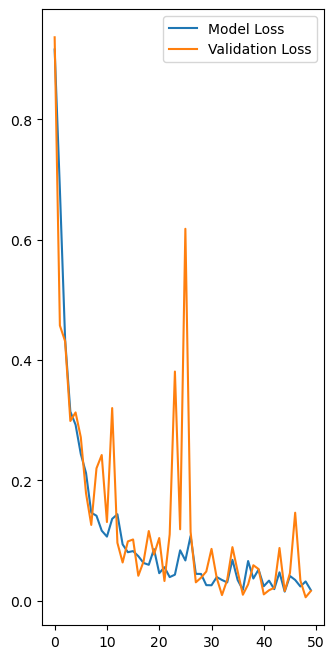

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), loss, label= "Model Loss")
plt.plot(range(50), validation_loss, label= "Validation Loss")
plt.legend(loc= "upper right")

First image to predict
Actual label: Potato___Late_blight
1/1 [==============================] - 0s 392ms/step
Predicted label: Potato___Late_blight


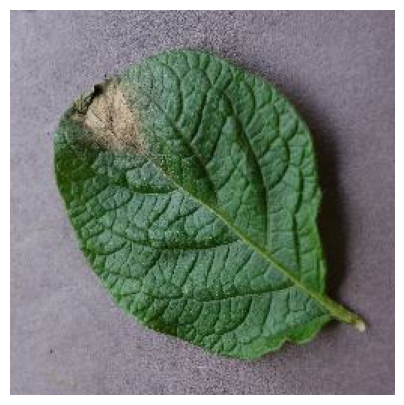

In [67]:
for image_batch, label_batch in test_ds.take(1):
    first_image= image_batch[0].numpy().astype("uint8")
    first_label= label_batch[0].numpy()
    
    print("First image to predict")
    plt.figure(figsize=(5,5))
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual label:", classNames[first_label])
    
    predictions= model.predict(image_batch)
    print("Predicted label:", classNames[np.argmax(predictions[0])])

In [ ]:
def predict(model, im)